In [1]:
import numpy as np

#### helper functions ####
def K(x1, x2):
    """
    description:
        calculate the kernel value of x1 and x2
    args:
        x1: a data point
        x2: a data point
    returns:
        the kernel value of x1 and x2
    """
    return x1.dot(x2.T)

#### stopping criteria 2 ####
def stopping_criteria2(alphas, Y, X, H, C, eps):
    """
    description:
        stopping criteria 2 for SMO algorithm
    args:
        alphas: the alpha values
        Y: the labels
        C: the regularization parameter
        eps: the tolerance
    returns:
        True if stopping criteria 2 is satisfied, False otherwise
    """
    l = len(alphas) # number of data points
    e = np.ones(l) # vector of ones
    delta_d = lambda alpha, H: np.dot(H, alpha) - e # delta_d function

    Iup, Ilow = [], [] # initialize the indices of the working set B
    for i in range(l):
        if (alphas[i] < C and Y[i] == 1) or (alphas[i] > 0 and Y[i] == -1): # if the point is in the upper set
            Iup.append(i)
        if (alphas[i] > 0 and Y[i] == 1) or (alphas[i] < C and Y[i] == -1): # if the point is in the lower set 
            Ilow.append(i)

    D = delta_d(alphas, H) # calculate delta_d
    d_up = [-Y[i] * D[i] for i in Iup] # calculate d_up for each point in the upper set
    d_low = [-Y[i] * D[i] for i in Ilow] # calculate d_low for each point in the lower set

    M, m = min(d_low), max(d_up) # calculate M and m
    if m - M <= eps: # if stopping criteria 2 is satisfied
        return True
    return False

#### selecting working set B ####
def selectB(alphas, Y, H, C):
    """
    description:
        select the working set B
    args:   
        alphas: the alpha values
        Y: the labels
        H: the Hessian matrix
        C: the regularization parameter
    returns:
        the indices of the working set B
    """
    l = len(alphas) # number of data points
    e = np.ones(l) # vector of ones
    delta_d = lambda alpha, H: np.dot(H, alpha) - e # delta_d function 
    D = delta_d(alphas, H) # calculate delta_d

    Iup, Ilow = [], [] # initialize the indices of the working set B
    for t in range(l): # loop over the data points
        if (alphas[t] < C and Y[t] == 1) or (alphas[t] > 0 and Y[t] == -1): # if the point is in the upper set
            Iup.append(t)
        if (alphas[t] > 0 and Y[t] == 1) or (alphas[t] < C and Y[t] == -1): # if the point is in the lower set
            Ilow.append(t)

    d_up = np.array([(Y[i] * D[i], i) for i in Iup]) # calculate d_up for each point in the upper set
    d_low = np.array([(Y[i] * D[i], i) for i in Ilow]) # calculate d_low for each point in the lower set

    # return the indices of max d_up and min d_low
    return int(d_up[d_up[:, 0].argmax()][1]), int(d_low[d_low[:, 0].argmin()][1])

#### solving the 2-variable subproblem ####
def solve_subproblem(alphas, X, Y, C, i, j, eps):
    """
    description:
        solve the 2-variable subproblem
    args:
        alphas : the alpha values 
        X : the data
        Y : the labels
        C : the regularization parameter
        i : the index of the first variable
        j : the index of the second variable
        eps : the tolerance
    returns:
        the new alpha values
    """
    if i == j: # if i == j, return 0
        return (0, 0)
    
    l = X.shape[0] # number of data points
    a1_old, a2_old = alphas[i], alphas[j] # save the old values
    
    if Y[i] != Y[j]: # if the labels are different
        U = max(0, a2_old - a1_old)
        V = min(C, C + a2_old - a1_old)
    else: # if the labels are the same
        U = max(0, a1_old + a2_old - C)
        V = min(C, a1_old + a2_old)

    if U == V: # if U == V, return 0
        return (0, 0)

    b11, b12, b22 = K(X[i], X[i]), K(X[i], X[j]), K(X[j], X[j]) # calculate the kernel values
    eta = b11 + b22 - 2 * b12 # calculate eta value 

    if eta > 0: # if eta > 0
        b1 = sum([Y[t] * alphas[t] * K(X[t], X[0]) for t in range(l) if (t != j and t != i)]) # calculate b1 and b2
        b2 = sum([Y[t] * alphas[t] * K(X[t], X[1]) for t in range(l) if (t != j and t != i)])
        E = b1 - b2 + a1_old * Y[i] * (b11 - b12) + a2_old * Y[j] * (b12 - b22) - Y[i] + Y[j] # calculate the error

        a2_new = a2_old + (Y[j] * E )/ eta # calculate the new alpha values
        if a2_new > V: # clip the values
            a2_new = V
        elif a2_new < U: 
            a2_new = U
    else: 
        f1 = Y[i] * (a1_old - a2_old) * b11 + Y[j] * a2_old * b12 + Y[i] * a1_old - 1 # calculate the objective function values
        f2 = Y[i] * (a1_old - a2_old) * b12 + Y[j] * a2_old * b22 + Y[j] * a2_old - 1
        Lobj = U * f1 + U * U * f2 / 2 
        Hobj = V * f1 + V * V * f2 / 2 
        if Lobj < Hobj - eps: # clip the values
            a2_new = U
        elif Lobj > Hobj + eps:
            a2_new = V
        else:
            a2_new = a2_old
    
    if abs(a2_new - a2_old) < eps * (a2_new + a2_old + eps): # if the change is too small, return 0
        return (0, 0)

    a1_new = a1_old + Y[i] * Y[j] * (a2_old - a2_new) # calculate the new alpha values
    return (a1_new, a2_new)

#### SMO algorithm ####
def SMO(X, Y, C, eps, max_iter=1000):
    """
    description:
        SMO algorithm for SVM
    args:
        X: the data
        Y: the labels
        C: the regularization parameter
        eps: the tolerance
        max_iter: the maximum number of iterations
    returns:
        alphas: the alpha values
    """
    l = X.shape[0] # the number of data points
    alphas = np.zeros(l) # initialize the alpha values
    H = np.dot(np.dot(Y.T, Y), K(X, X)) # the Hessian matrix
    iter = 0 # the iteration number
    while iter < max_iter: 
        i, j = selectB(alphas, Y, H, C) # select the working set B
        a1_new, a2_new = solve_subproblem(alphas, X, Y, C, i, j, eps=eps) # solve the 2-variable subproblem
        alphas[i], alphas[j] = a1_new, a2_new # update the alpha values
        if stopping_criteria2(alphas, Y, X, H, C, eps=eps): 
            break # stopping criteria
        iter += 1
        if iter%100 == 0 : print("\riter: ", iter) # print the iteration number
    return alphas

In [2]:
def twsvm(X, y, C, eps, max_iter=1000):
    y1 = np.where(y == 1)[0]
    y2 = np.where(y == -1)[0]

    X1, X2 = X[y1], X[y2]

    alpha1 = SMO(X2, -np.ones(len(X2)), C, eps, max_iter) 
    alpha2 = SMO(X1, np.ones(len(X1)), C, eps, max_iter)

    w1 = np.dot((alpha1 - alpha2).T, X1 - X2)
    b1 = np.mean(np.ones(len(X1)) - np.dot(X1, alpha2))

    w2 = np.dot((alpha2 - alpha1).T, X2 - X1)
    b2 = np.mean(np.ones(len(X2)) - np.dot(X2, alpha1))

    return w1, b1, w2, b2


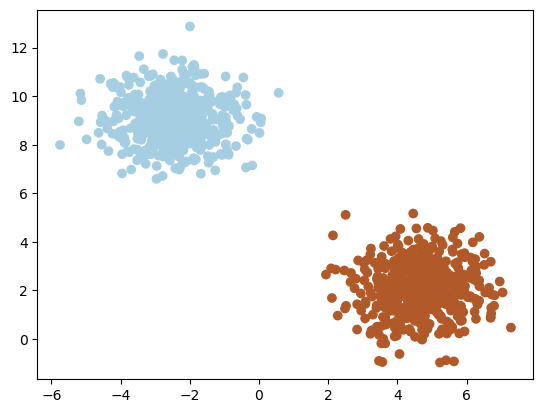

In [3]:
# generate data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=2, random_state=42)
y[y == 0] = -1

# visualize data
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [4]:
# train model
w1, b1, w2, b2 = twsvm(X, y, C=1, eps=1e-3, max_iter=1000)

print(w1, b1, w2, b2)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
def plot_decision_boundary(X, y, w1, b1, w2, b2):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # plot the two decision boundaries
    Z = twsvm_predict(np.c_[xx.ravel(), yy.ravel()], w1, b1, w2, b2)
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    
    plt.show()

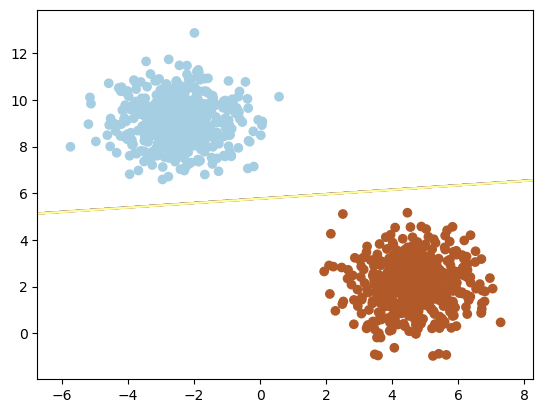

In [ ]:
# visualize data with decision boundary
plot_decision_boundary(X, y, w1, b1, w2, b2)